DME Data Analysis

Importing data for 2017...
✓ Data for 2017 imported successfully. Shape: (75343, 94)
Importing data for 2018...
✓ Data for 2018 imported successfully. Shape: (75805, 94)
Importing data for 2019...
✓ Data for 2019 imported successfully. Shape: (72775, 94)
Importing data for 2020...
✓ Data for 2020 imported successfully. Shape: (69398, 94)
Importing data for 2021...
✓ Data for 2021 imported successfully. Shape: (68227, 94)
Importing data for 2022...
✓ Data for 2022 imported successfully. Shape: (66406, 94)

All available data files have been imported.

1. Data Overview
---------------

Summary statistics across years:
 Year  Suppliers  Total Beneficiaries  Total Claims  Total Payments ($)
 2017      75343            9,785,207    45,062,431       3,254,409,211
 2018      75805            9,800,756    45,449,204       3,662,130,039
 2019      72775            9,708,429    45,291,956       4,085,965,621
 2020      69398            9,018,653    43,833,234       4,428,954,0

/var/folders/g6/2s70_fq11hn4czzmpgd40ky80000gn/T/ipykernel_14928/2743659796.py:484: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ph_values, y=ph_labels, palette="Blues_d", ax=axes[0])
/var/folders/g6/2s70_fq11hn4czzmpgd40ky80000gn/T/ipykernel_14928/2743659796.py:497: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bh_values, y=bh_labels, palette="Oranges_d", ax=axes[1])
/var/folders/g6/2s70_fq11hn4czzmpgd40ky80000gn/T/ipykernel_14928/2743659796.py:548: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Medicare Payments (Numeric)', y='Suppl

Generating top suppliers visualization...
Generating geographical distribution visualization...
Generating year-over-year changes visualization...


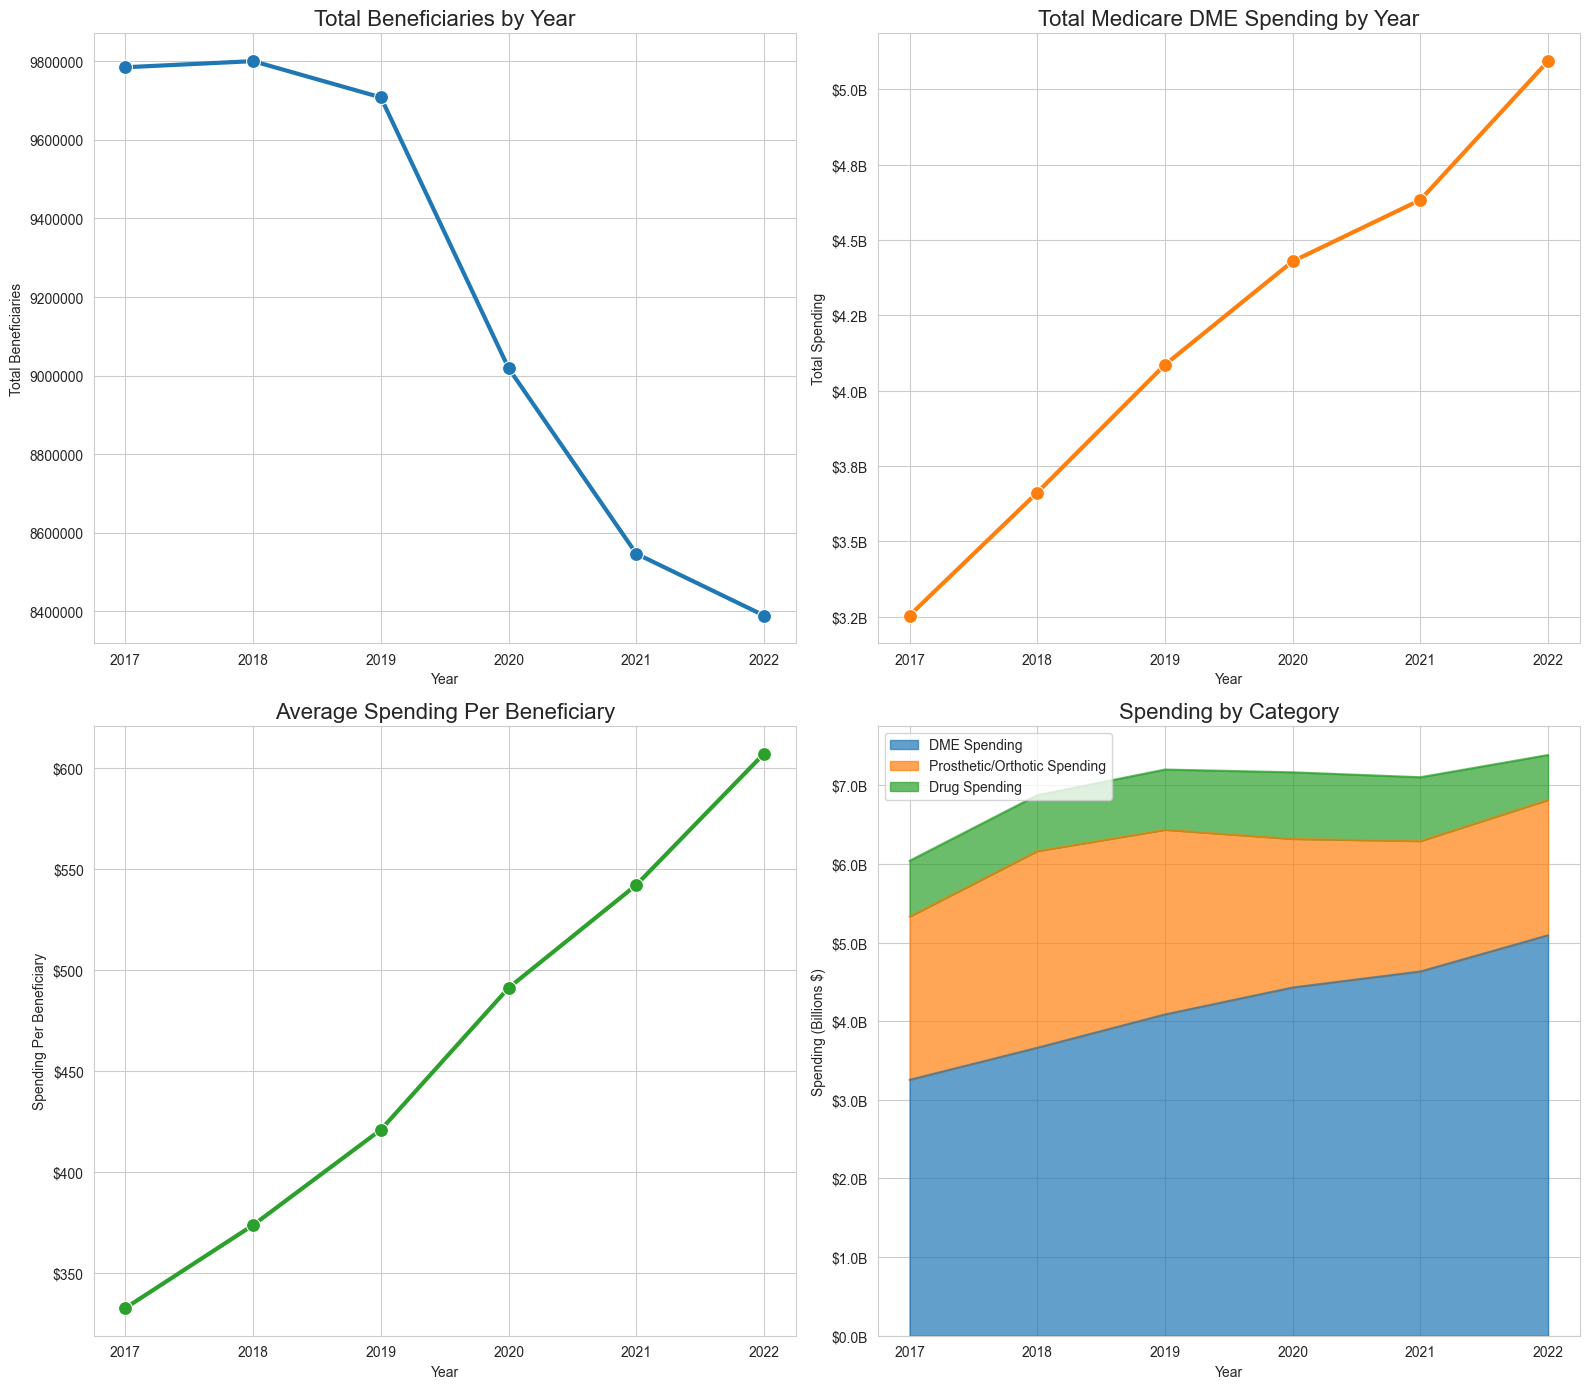

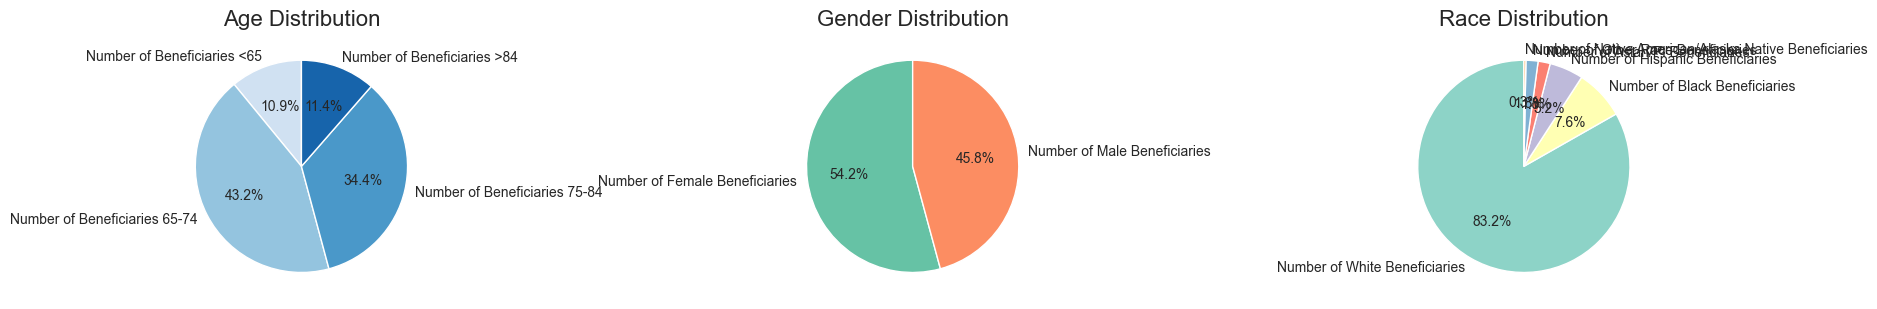

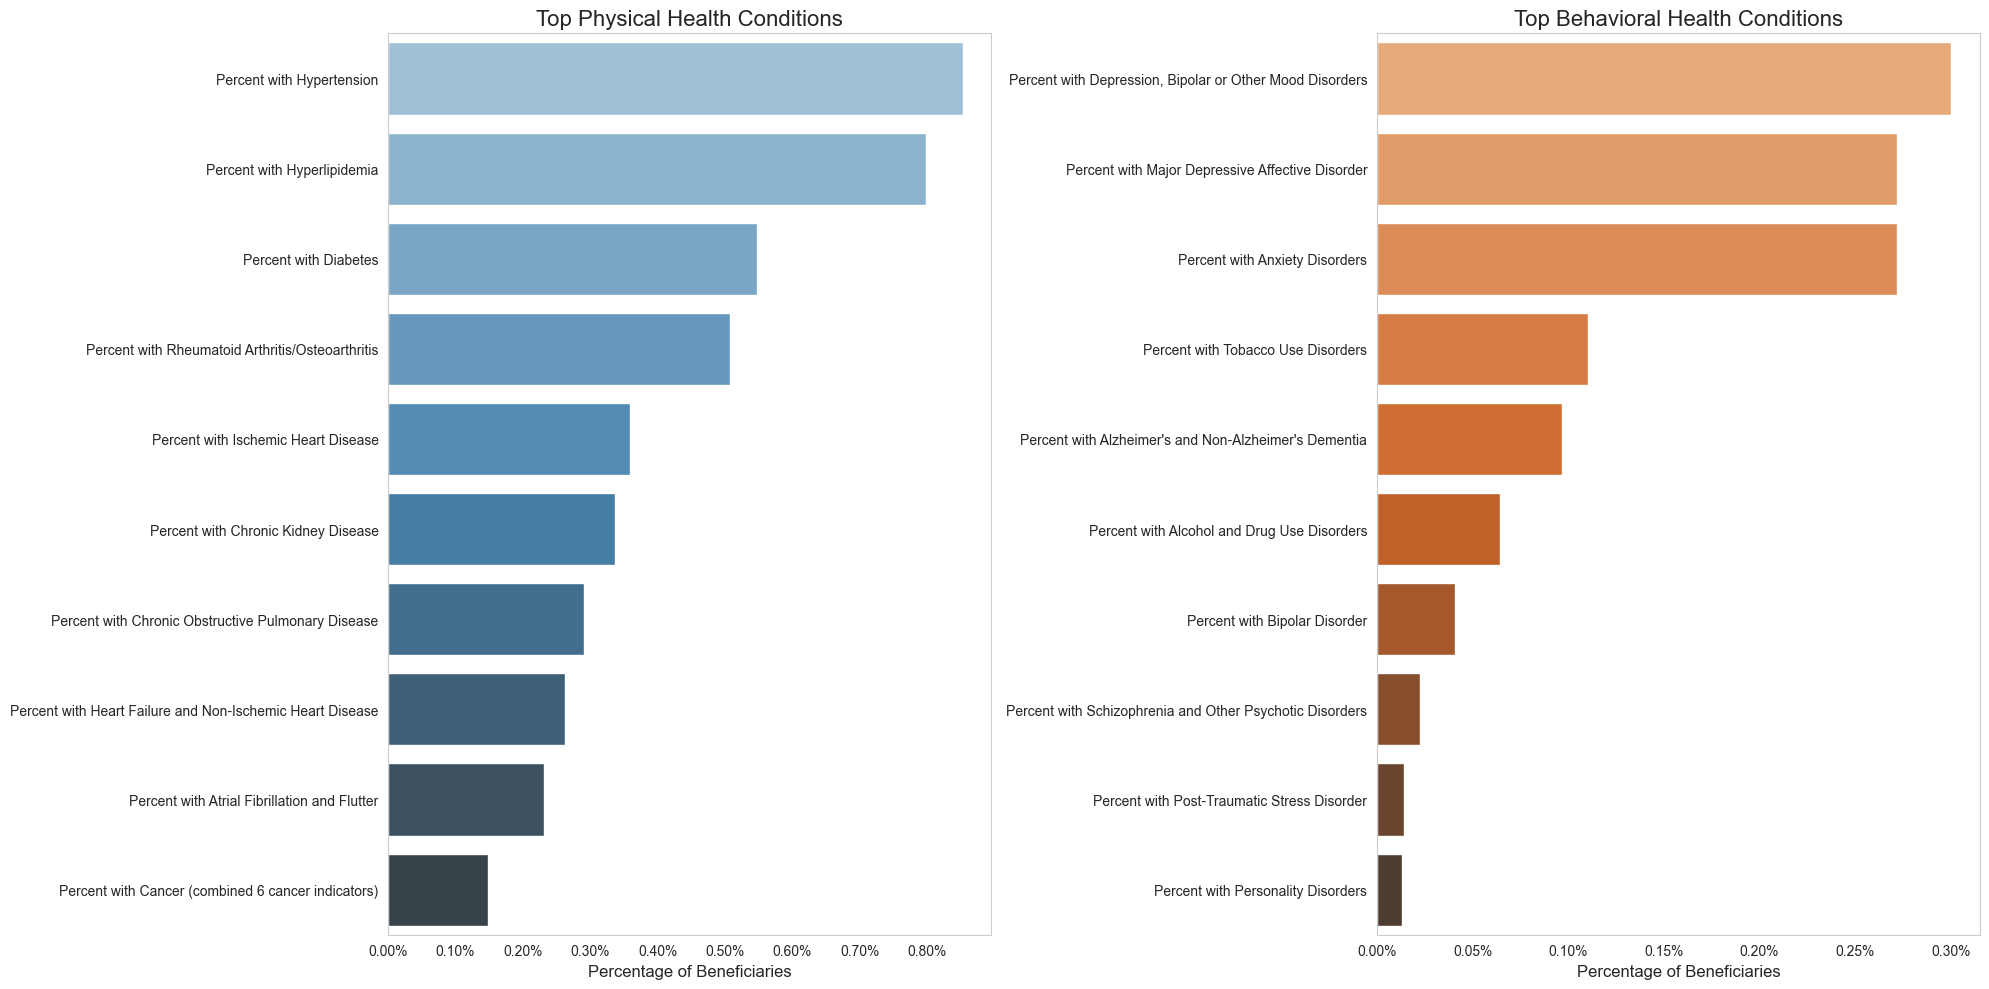

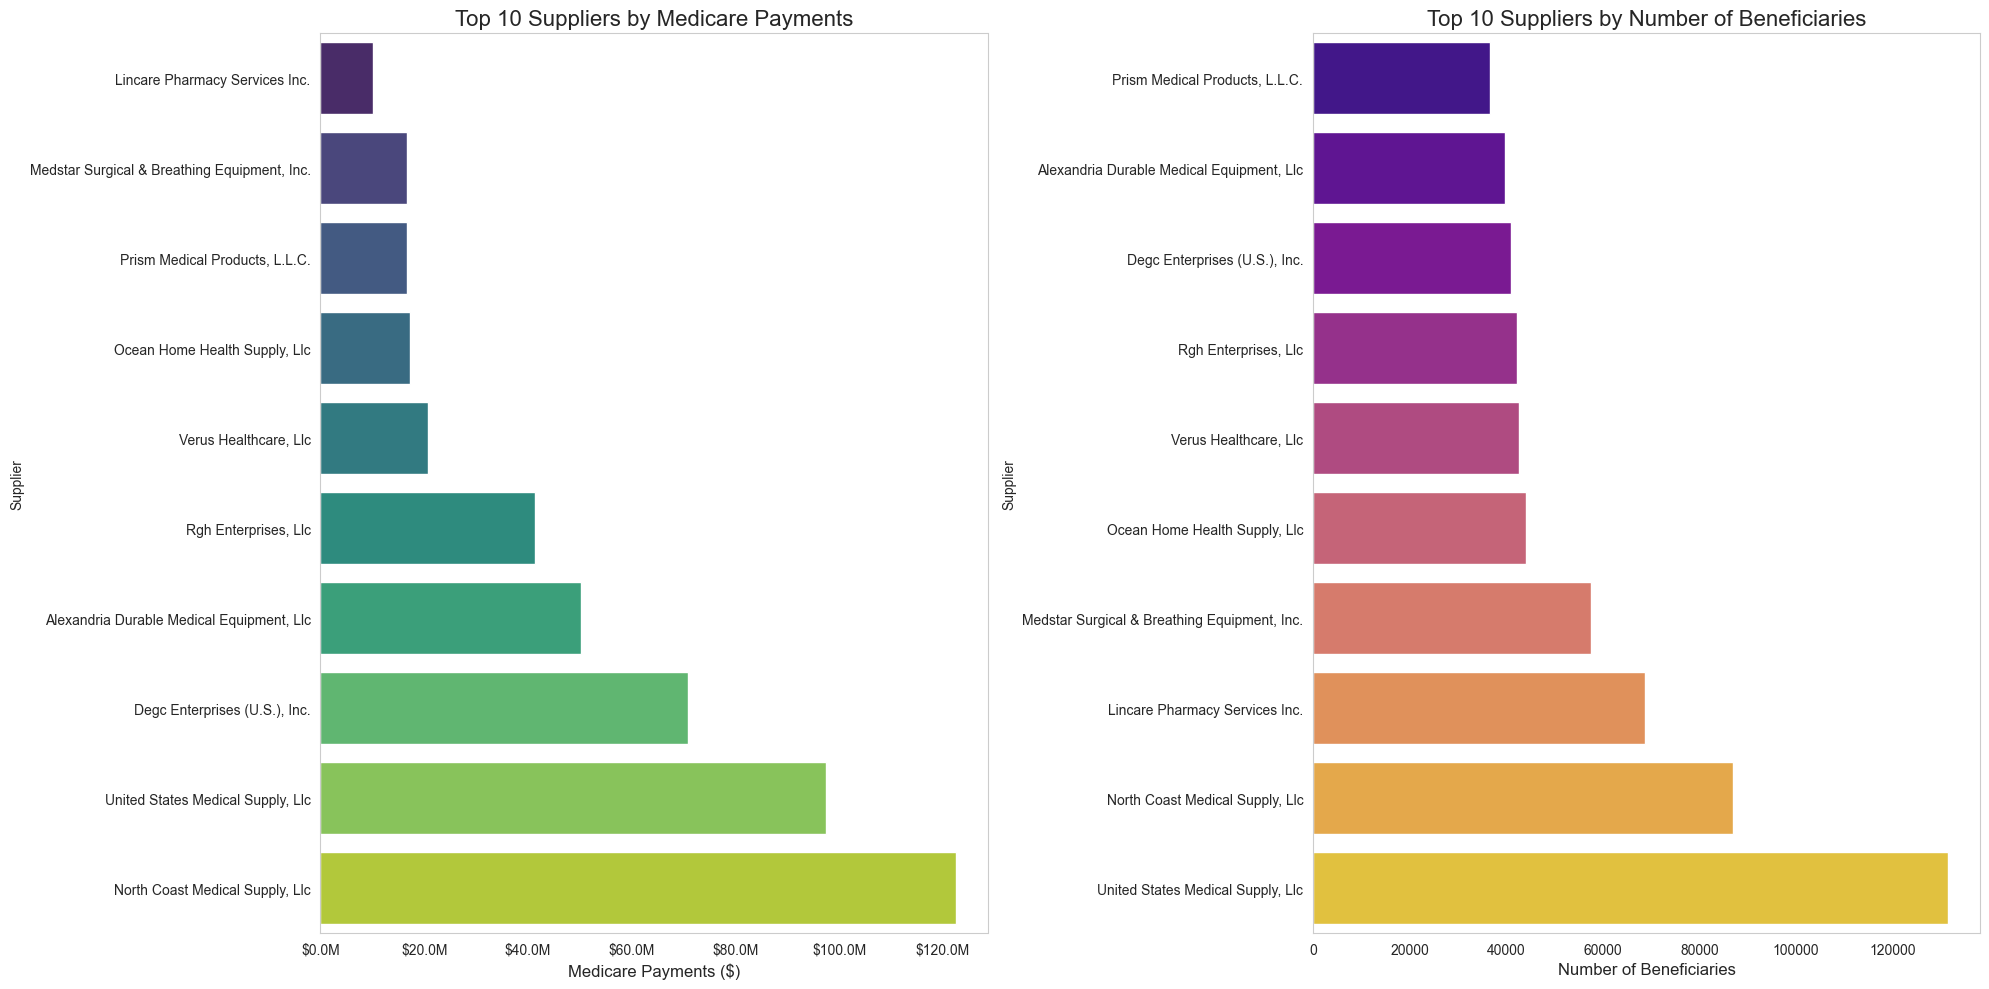

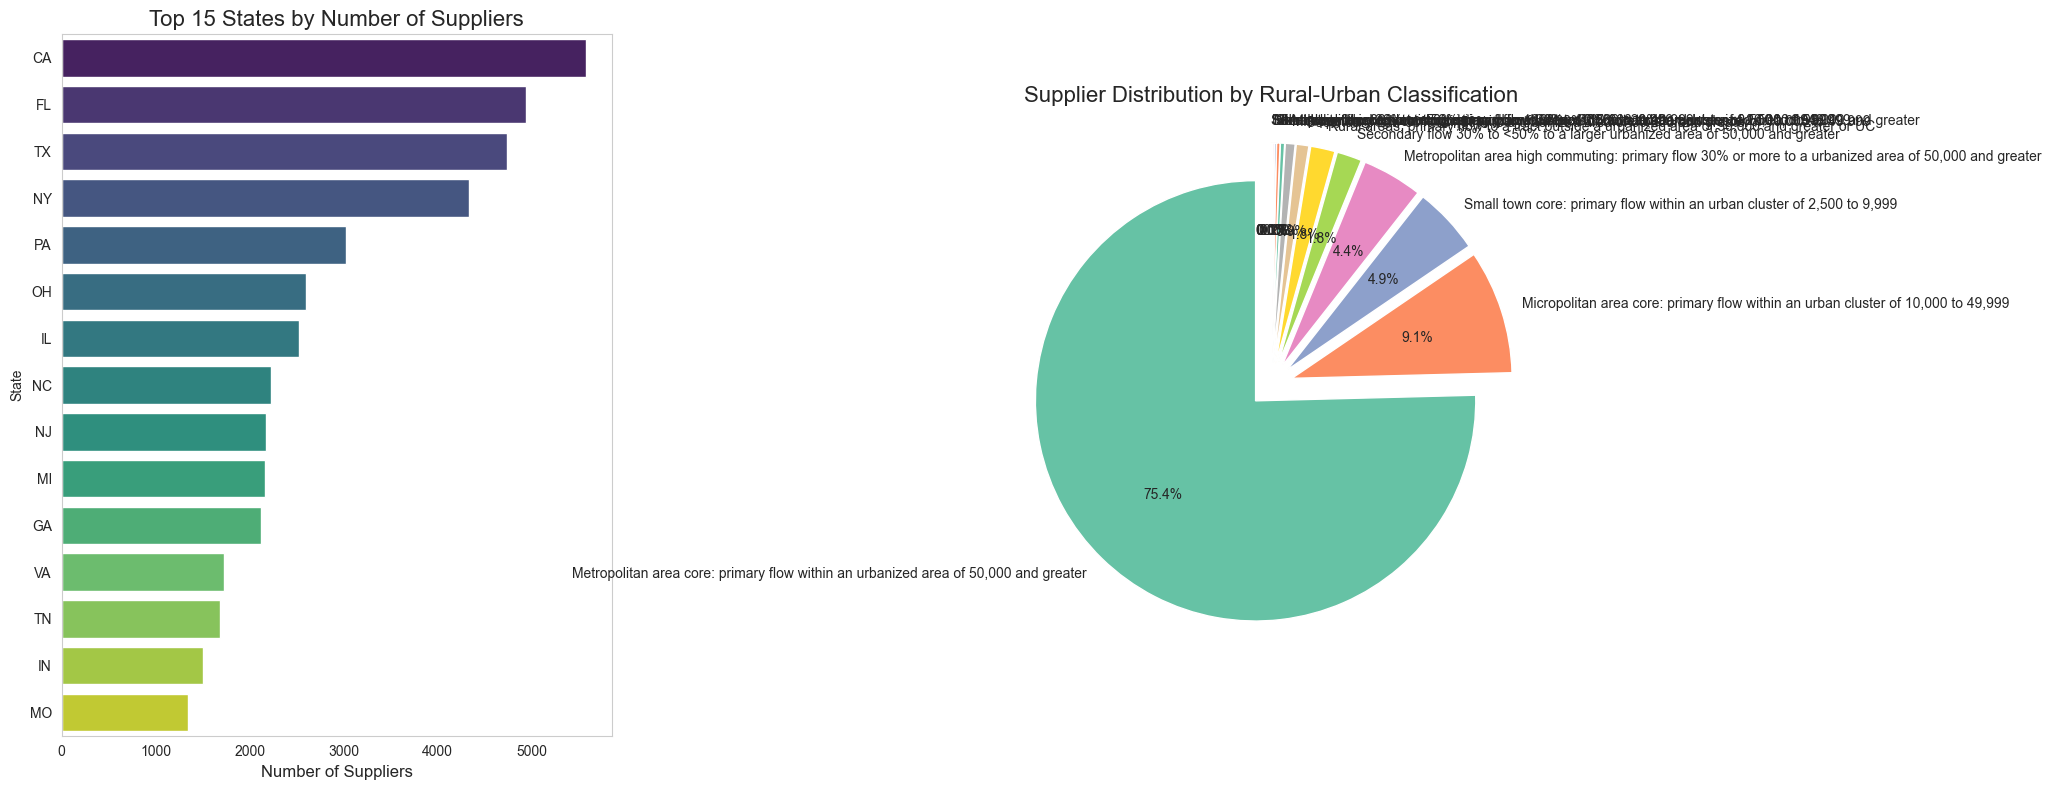

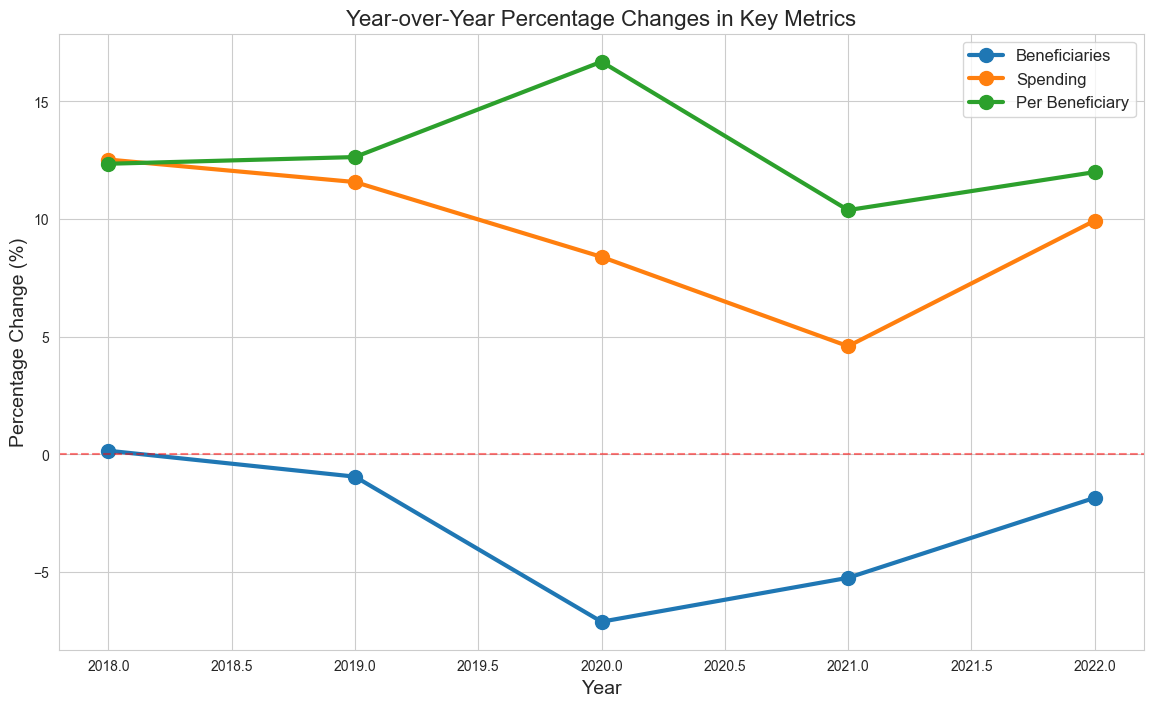

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
DME Data Analysis Script
This script imports and analyzes the DME data files by year.
"""

import pandas as pd
import numpy as np
import os
from pprint import pprint
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import sys


def import_dme_data(file_path):
    """
    Import and preprocess DME data from a CSV file.

    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing DME data

    Returns:
    --------
    df : DataFrame
        Processed DataFrame containing DME data
    """
    print(f"Importing data from {file_path}...")

    try:
        # Import data with appropriate dtypes to handle monetary values correctly
        df = pd.read_csv(file_path, low_memory=False)

        # Convert monetary columns to numeric
        money_columns = [
            col for col in df.columns if 'Pymt' in col or 'Amt' in col]
        for col in money_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        print(f"Successfully imported data with shape: {df.shape}")
        return df

    except Exception as e:
        print(f"Error importing data: {str(e)}")
        return None


# Data dictionary mapping variable names to their descriptions
DATA_DICTIONARY = {
    # Supplier Information
    "Suplr_NPI": "Supplier NPI - NPI for the Supplier on the DMEPOS claim",
    "Suplr_Prvdr_Last_Name_Org": "Supplier Last Name/Organization Name - When registered as individual, the Supplier's last name. When registered as organization, this is the organization name",
    "Suplr_Prvdr_First_Name": "Supplier First Name - When registered as individual, the Supplier's first name",
    "Suplr_Prvdr_MI": "Supplier Middle Initial - When registered as individual, the Supplier's middle initial",
    "Suplr_Prvdr_Crdntls": "Supplier Credentials - When registered as individual, these are the Supplier's credentials",
    "Suplr_Prvdr_Gndr": "Supplier Gender - When registered as individual, this is the Supplier's gender",
    "Suplr_Prvdr_Ent_Cd": "Supplier Entity Code - 'I' identifies Suppliers registered as individuals, 'O' identifies Suppliers registered as organizations",
    "Suplr_Prvdr_St1": "Supplier Street 1 - First line of the Supplier's street address",
    "Suplr_Prvdr_St2": "Supplier Street 2 - Second line of the Supplier's street address",
    "Suplr_Prvdr_City": "Supplier City - The city where the Supplier is located",
    "Suplr_Prvdr_State_Abrvtn": "Supplier State - State postal abbreviation where the Supplier is located",
    "Suplr_Prvdr_State_FIPS": "Supplier State FIPS Code - FIPS code for Supplier's state",
    "Suplr_Prvdr_Zip5": "Supplier ZIP - The Supplier's ZIP code",
    "Suplr_Prvdr_RUCA": "Supplier RUCA - Rural-Urban Commuting Area Code for the Supplier ZIP code",
    "Suplr_Prvdr_RUCA_Desc": "Supplier RUCA Description - Description of Rural-Urban Commuting Area (RUCA) Code",
    "Suplr_Prvdr_Cntry": "Supplier Country - Country where the Supplier is located",
    "Suplr_Prvdr_Spclty_Desc": "Supplier Provider Specialty Description - Derived from Medicare provider/supplier specialty code",
    "Suplr_Prvdr_Spclty_Srce": "Supplier Provider Specialty Source - Source of the Supplier Specialty (claims-specialty or NPPES-specialty)",

    # Total Supplier Claims/Services
    "Tot_Suplr_HCPCS_Cds": "Number of Supplier HCPCS - Total unique DMEPOS product/service HCPCS codes",
    "Tot_Suplr_Benes": "Number of Supplier Beneficiaries - Total unique beneficiaries (<11 are suppressed)",
    "Tot_Suplr_Clms": "Number of Supplier Claims - Total DMEPOS claims submitted",
    "Tot_Suplr_Srvcs": "Number of Supplier Services - Total DMEPOS products/services rendered",
    "Suplr_Sbmtd_Chrgs": "Supplier Submitted Charges - Total charges submitted for DMEPOS products/services",
    "Suplr_Mdcr_Alowd_Amt": "Supplier Medicare Allowed Amount - Total Medicare allowed amount",
    "Suplr_Mdcr_Pymt_Amt": "Supplier Medicare Payment Amount - Amount Medicare paid after deductible/coinsurance",
    "Suplr_Mdcr_Stdzd_Pymt_Amt": "Supplier Medicare Standard Payment Amount - Standardized Medicare payments",

    # DME-specific Fields
    "DME_Sprsn_Ind": "Durable Medical Equipment Suppression Indicator - '*'=suppressed (1-10 claims), '#'=counter-suppressed",
    "DME_Tot_Suplr_HCPCS_Cds": "Number of DME HCPCS - Total unique DME HCPCS codes",
    "DME_Tot_Suplr_Benes": "Number of DME Beneficiaries - Total unique beneficiaries with DME claims (<11 are suppressed)",
    "DME_Tot_Suplr_Clms": "Number of DME Claims - Total DME claims submitted",
    "DME_Tot_Suplr_Srvcs": "Number of DME Services - Total DME products/services rendered",
    "DME_Suplr_Sbmtd_Chrgs": "DME Submitted Charges - Total charges submitted for DME products/services",
    "DME_Suplr_Mdcr_Alowd_Amt": "DME Medicare Allowed Amount - Total Medicare allowed amount for DME",
    "DME_Suplr_Mdcr_Pymt_Amt": "DME Medicare Payment Amount - Amount Medicare paid for DME after deductible/coinsurance",
    "DME_Suplr_Mdcr_Stdzd_Pymt_Amt": "DME Medicare Standard Payment Amount - Standardized Medicare payments for DME",

    # Prosthetic and Orthotic Fields
    "POS_Sprsn_Ind": "Prosthetic and Orthotic Suppression Indicator - '*'=suppressed (1-10 claims), '#'=counter-suppressed",
    "POS_Tot_Suplr_HCPCS_Cds": "Number of Prosthetic/Orthotic HCPCS - Total unique prosthetic/orthotic HCPCS codes",
    "POS_Tot_Suplr_Benes": "Number of Prosthetic/Orthotic Beneficiaries - Total unique beneficiaries",
    "POS_Tot_Suplr_Clms": "Number of Prosthetic/Orthotic Claims - Total prosthetic/orthotic claims submitted",
    "POS_Tot_Suplr_Srvcs": "Number of Prosthetic/Orthotic Services - Total prosthetic/orthotic products/services",
    "POS_Suplr_Sbmtd_Chrgs": "Prosthetic/Orthotic Submitted Charges - Total charges submitted for prosthetic/orthotic",
    "POS_Suplr_Mdcr_Alowd_Amt": "Prosthetic/Orthotic Medicare Allowed Amount - Total Medicare allowed amount",
    "POS_Suplr_Mdcr_Pymt_Amt": "Prosthetic/Orthotic Medicare Payment Amount - Amount Medicare paid after deductible/coinsurance",
    "POS_Suplr_Mdcr_Stdzd_Pymt_Amt": "Prosthetic/Orthotic Medicare Standard Payment Amount - Standardized Medicare payments",

    # Drug and Nutritional Fields
    "Drug_Sprsn_Ind": "Drug and Nutritional Suppression Indicator - '*'=suppressed (1-10 claims), '#'=counter-suppressed",
    "Drug_Tot_Suplr_HCPCS_Cds": "Number of Drug/Nutritional HCPCS - Total unique drug/nutritional HCPCS codes",
    "Drug_Tot_Suplr_Benes": "Number of Drug/Nutritional Beneficiaries - Total unique beneficiaries",
    "Drug_Tot_Suplr_Clms": "Number of Drug/Nutritional Claims - Total drug/nutritional claims submitted",
    "Drug_Tot_Suplr_Srvcs": "Number of Drug/Nutritional Services - Total drug/nutritional products/services",
    "Drug_Suplr_Sbmtd_Chrgs": "Drug/Nutritional Submitted Charges - Total charges submitted for drug/nutritional",
    "Drug_Suplr_Mdcr_Alowd_Amt": "Drug/Nutritional Medicare Allowed Amount - Total Medicare allowed amount",
    "Drug_Suplr_Mdcr_Pymt_Amt": "Drug/Nutritional Medicare Payment Amount - Amount Medicare paid after deductible/coinsurance",
    "Drug_Suplr_Mdcr_Stdzd_Pymt_Amt": "Drug/Nutritional Medicare Standard Payment Amount - Standardized Medicare payments",

    # Beneficiary Demographics
    "Bene_Avg_Age": "Average Age of Beneficiaries - Average age at end of calendar year or time of death",
    "Bene_Age_LT_65_Cnt": "Number of Beneficiaries <65 - Count of beneficiaries under 65 years old",
    "Bene_Age_65_74_Cnt": "Number of Beneficiaries 65-74 - Count of beneficiaries between 65-74 years old",
    "Bene_Age_75_84_Cnt": "Number of Beneficiaries 75-84 - Count of beneficiaries between 75-84 years old",
    "Bene_Age_GT_84_Cnt": "Number of Beneficiaries >84 - Count of beneficiaries over 84 years old",
    "Bene_Feml_Cnt": "Number of Female Beneficiaries - Count of female beneficiaries",
    "Bene_Male_Cnt": "Number of Male Beneficiaries - Count of male beneficiaries",
    "Bene_Race_Wht_Cnt": "Number of White Beneficiaries - Count of non-Hispanic white beneficiaries",
    "Bene_Race_Black_Cnt": "Number of Black Beneficiaries - Count of non-Hispanic Black/African American beneficiaries",
    "Bene_Race_Api_Cnt": "Number of Asian/PI Beneficiaries - Count of Asian Pacific Islander beneficiaries",
    "Bene_Race_Hspnc_Cnt": "Number of Hispanic Beneficiaries - Count of Hispanic beneficiaries",
    "Bene_Race_Natind_Cnt": "Number of Native American/Alaska Native Beneficiaries - Count of American Indian/Alaska Native beneficiaries",
    "Bene_Race_Othr_Cnt": "Number of Other Race Beneficiaries - Count of beneficiaries with race not elsewhere classified",
    "Bene_Ndual_Cnt": "Number of Medicare & Medicaid Beneficiaries - Count of dual-eligible beneficiaries",
    "Bene_Dual_Cnt": "Number of Medicare-Only Beneficiaries - Count of Medicare-only beneficiaries",

    # Beneficiary Health Conditions (Mental/Behavioral Health)
    "Bene_CC_BH_ADHD_OthCD_V1_Pct": "Percent with ADHD and Other Conduct Disorders",
    "Bene_CC_BH_Alcohol_Drug_V1_Pct": "Percent with Alcohol and Drug Use Disorders",
    "Bene_CC_BH_Tobacco_V1_Pct": "Percent with Tobacco Use Disorders",
    "Bene_CC_BH_Alz_NonAlzdem_V2_Pct": "Percent with Alzheimer's and Non-Alzheimer's Dementia",
    "Bene_CC_BH_Anxiety_V1_Pct": "Percent with Anxiety Disorders",
    "Bene_CC_BH_Bipolar_V1_Pct": "Percent with Bipolar Disorder",
    "Bene_CC_BH_Mood_V2_Pct": "Percent with Depression, Bipolar or Other Mood Disorders",
    "Bene_CC_BH_Depress_V1_Pct": "Percent with Major Depressive Affective Disorder",
    "Bene_CC_BH_PD_V1_Pct": "Percent with Personality Disorders",
    "Bene_CC_BH_PTSD_V1_Pct": "Percent with Post-Traumatic Stress Disorder",
    "Bene_CC_BH_Schizo_OthPsy_V1_Pct": "Percent with Schizophrenia and Other Psychotic Disorders",

    # Beneficiary Health Conditions (Physical Health)
    "Bene_CC_PH_Asthma_V2_Pct": "Percent with Asthma",
    "Bene_CC_PH_Afib_V2_Pct": "Percent with Atrial Fibrillation and Flutter",
    "Bene_CC_PH_Cancer6_V2_Pct": "Percent with Cancer (combined 6 cancer indicators)",
    "Bene_CC_PH_CKD_V2_Pct": "Percent with Chronic Kidney Disease",
    "Bene_CC_PH_COPD_V2_Pct": "Percent with Chronic Obstructive Pulmonary Disease",
    "Bene_CC_PH_Diabetes_V2_Pct": "Percent with Diabetes",
    "Bene_CC_PH_HF_NonIHD_V2_Pct": "Percent with Heart Failure and Non-Ischemic Heart Disease",
    "Bene_CC_PH_Hyperlipidemia_V2_Pct": "Percent with Hyperlipidemia",
    "Bene_CC_PH_Hypertension_V2_Pct": "Percent with Hypertension",
    "Bene_CC_PH_IschemicHeart_V2_Pct": "Percent with Ischemic Heart Disease",
    "Bene_CC_PH_Osteoporosis_V2_Pct": "Percent with Osteoporosis",
    "Bene_CC_PH_Parkinson_V2_Pct": "Percent with Parkinson's Disease",
    "Bene_CC_PH_Arthritis_V2_Pct": "Percent with Rheumatoid Arthritis/Osteoarthritis",
    "Bene_CC_PH_Stroke_TIA_V2_Pct": "Percent with Stroke/Transient Ischemic Attack",

    # Risk Score
    "Bene_Avg_Risk_Scre": "Average HCC Risk Score of Beneficiaries"
}


def get_column_category(column_name):
    """Return the category for a given column name based on prefix."""
    if column_name.startswith('Suplr_'):
        return "Supplier Information"
    elif column_name.startswith('DME_'):
        return "Durable Medical Equipment"
    elif column_name.startswith('POS_'):
        return "Prosthetics and Orthotics"
    elif column_name.startswith('Drug_'):
        return "Drug and Nutritional Products"
    elif column_name.startswith('Bene_CC_BH_'):
        return "Beneficiary Behavioral Health Conditions"
    elif column_name.startswith('Bene_CC_PH_'):
        return "Beneficiary Physical Health Conditions"
    elif column_name.startswith('Bene_'):
        return "Beneficiary Demographics"
    else:
        return "Other"


def get_top_suppliers(df, top_n=10):
    """Return the top suppliers by number of beneficiaries."""
    top_suppliers = df.sort_values(
        'DME_Tot_Suplr_Benes', ascending=False).head(top_n)

    # Format results for better readability
    results = []
    for _, row in top_suppliers.iterrows():
        supplier_name = row['Suplr_Prvdr_Last_Name_Org']
        beneficiaries = row['DME_Tot_Suplr_Benes']
        claims = row['DME_Tot_Suplr_Clms']
        payments = row['DME_Suplr_Mdcr_Pymt_Amt']

        results.append({
            'Supplier': supplier_name,
            'Beneficiaries': beneficiaries,
            'Claims': claims,
            'Medicare Payments': f"${payments:,.2f}"
        })

    return pd.DataFrame(results)


def get_beneficiary_demographics(df):
    """Analyze beneficiary demographics from the data."""
    # Extract age distribution
    age_cols = ['Bene_Age_LT_65_Cnt', 'Bene_Age_65_74_Cnt',
                'Bene_Age_75_84_Cnt', 'Bene_Age_GT_84_Cnt']
    age_totals = df[age_cols].sum()
    total_benes = age_totals.sum()
    age_pcts = (age_totals / total_benes * 100).round(2)

    # Extract gender distribution
    gender_cols = ['Bene_Feml_Cnt', 'Bene_Male_Cnt']
    gender_totals = df[gender_cols].sum()
    gender_pcts = (gender_totals / gender_totals.sum() * 100).round(2)

    # Extract race distribution
    race_cols = ['Bene_Race_Wht_Cnt', 'Bene_Race_Black_Cnt', 'Bene_Race_Api_Cnt',
                 'Bene_Race_Hspnc_Cnt', 'Bene_Race_Natind_Cnt', 'Bene_Race_Othr_Cnt']
    race_totals = df[race_cols].sum()
    race_pcts = (race_totals / race_totals.sum() * 100).round(2)

    # Format results with readable labels from data dictionary
    age_results = {DATA_DICTIONARY[col].split(
        ' - ')[0]: pct for col, pct in zip(age_cols, age_pcts)}
    gender_results = {DATA_DICTIONARY[col].split(
        ' - ')[0]: pct for col, pct in zip(gender_cols, gender_pcts)}
    race_results = {DATA_DICTIONARY[col].split(
        ' - ')[0]: pct for col, pct in zip(race_cols, race_pcts)}

    return {
        'Age Distribution': age_results,
        'Gender Distribution': gender_results,
        'Race Distribution': race_results
    }


def get_common_health_conditions(df):
    """Extract the most common health conditions among beneficiaries."""
    # Physical health conditions
    ph_cols = [col for col in df.columns if col.startswith(
        'Bene_CC_PH_') and col.endswith('_Pct')]
    ph_values = []

    for col in ph_cols:
        # Calculate weighted average (weighted by number of beneficiaries)
        weighted_avg = (df[col] * df['DME_Tot_Suplr_Benes']
                        ).sum() / df['DME_Tot_Suplr_Benes'].sum()
        ph_values.append((DATA_DICTIONARY[col], weighted_avg))

    # Behavioral health conditions
    bh_cols = [col for col in df.columns if col.startswith(
        'Bene_CC_BH_') and col.endswith('_Pct')]
    bh_values = []

    for col in bh_cols:
        # Calculate weighted average (weighted by number of beneficiaries)
        weighted_avg = (df[col] * df['DME_Tot_Suplr_Benes']
                        ).sum() / df['DME_Tot_Suplr_Benes'].sum()
        bh_values.append((DATA_DICTIONARY[col], weighted_avg))

    # Sort by prevalence
    ph_values.sort(key=lambda x: x[1], reverse=True)
    bh_values.sort(key=lambda x: x[1], reverse=True)

    return {
        'Physical Health Conditions': ph_values,
        'Behavioral Health Conditions': bh_values
    }


def analyze_spending_patterns(df_by_year):
    """Analyze spending patterns across years."""
    year_data = []

    for year, df in df_by_year.items():
        # Calculate total beneficiaries and spending
        total_benes = df['DME_Tot_Suplr_Benes'].sum()
        total_spend = df['DME_Suplr_Mdcr_Pymt_Amt'].sum()

        # Calculate spending per beneficiary
        spend_per_bene = total_spend / total_benes if total_benes > 0 else 0

        # Calculate distribution of spending by DME, POS, and Drug categories
        dme_spend = df['DME_Suplr_Mdcr_Pymt_Amt'].sum()
        pos_spend = df['POS_Suplr_Mdcr_Pymt_Amt'].sum()
        drug_spend = df['Drug_Suplr_Mdcr_Pymt_Amt'].sum()

        # Add to results
        year_data.append({
            'Year': year,
            'Total Beneficiaries': total_benes,
            'Total Spending': total_spend,
            'Spending Per Beneficiary': spend_per_bene,
            'DME Spending': dme_spend,
            'Prosthetic/Orthotic Spending': pos_spend,
            'Drug Spending': drug_spend
        })

    return pd.DataFrame(year_data)


# -------------------- Visualization Functions --------------------

def plot_spending_trends(spend_df):
    """
    Create visualizations for spending trends over time.

    Parameters:
    -----------
    spend_df : DataFrame
        DataFrame with yearly spending data, as returned by analyze_spending_patterns

    Returns:
    --------
    fig : matplotlib Figure
        The figure containing the visualizations
    """
    # Set the style
    sns.set_style('whitegrid')

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # Total beneficiaries by year
    sns.lineplot(x='Year', y='Total Beneficiaries', data=spend_df,
                 marker='o', linewidth=3, markersize=10, ax=axes[0, 0], color='#1f77b4')
    axes[0, 0].set_title('Total Beneficiaries by Year', fontsize=16)
    axes[0, 0].ticklabel_format(style='plain', axis='y')
    axes[0, 0].grid(True)

    # Total spending by year
    sns.lineplot(x='Year', y='Total Spending', data=spend_df,
                 marker='o', linewidth=3, markersize=10, ax=axes[0, 1], color='#ff7f0e')
    axes[0, 1].set_title('Total Medicare DME Spending by Year', fontsize=16)
    axes[0, 1].ticklabel_format(style='plain', axis='y')
    axes[0, 1].yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'${x/1e9:.1f}B'))
    axes[0, 1].grid(True)

    # Spending per beneficiary by year
    sns.lineplot(x='Year', y='Spending Per Beneficiary', data=spend_df,
                 marker='o', linewidth=3, markersize=10, ax=axes[1, 0], color='#2ca02c')
    axes[1, 0].set_title('Average Spending Per Beneficiary', fontsize=16)
    axes[1, 0].yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'${x:.0f}'))
    axes[1, 0].grid(True)

    # Spending by category stacked area chart
    category_data = spend_df[['Year', 'DME Spending',
                              'Prosthetic/Orthotic Spending', 'Drug Spending']]
    category_data_stacked = category_data.set_index('Year')

    # Convert to billions for better readability
    category_data_stacked = category_data_stacked / 1e9

    # Plot stacked area chart
    category_data_stacked.plot.area(stacked=True, ax=axes[1, 1],
                                    color=['#1f77b4', '#ff7f0e', '#2ca02c'],
                                    alpha=0.7)
    axes[1, 1].set_title('Spending by Category', fontsize=16)
    axes[1, 1].set_ylabel('Spending (Billions $)')
    axes[1, 1].yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'${x:.1f}B'))
    axes[1, 1].legend(loc='upper left')
    axes[1, 1].grid(True)

    plt.tight_layout()
    return fig


def plot_demographics(df, year=None):
    """
    Create visualizations for beneficiary demographics.

    Parameters:
    -----------
    df : DataFrame or dict
        Either a DataFrame for a specific year or the df_by_year dictionary
    year : int, optional
        If df is a dictionary, specify which year to visualize

    Returns:
    --------
    fig : matplotlib Figure
        The figure containing the visualizations
    """
    # If we have multiple years, extract the specified year
    if isinstance(df, dict) and year is not None:
        if year in df:
            df = df[year]
        else:
            raise ValueError(f"Year {year} not found in data")

    # Get demographics data
    demo_results = get_beneficiary_demographics(df)

    # Create a figure with 3 subplots for age, gender, and race
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Age distribution
    age_data = demo_results['Age Distribution']
    age_labels = list(age_data.keys())
    age_values = list(age_data.values())

    axes[0].pie(age_values, labels=age_labels, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Blues", len(age_labels)))
    axes[0].set_title('Age Distribution', fontsize=16)

    # Gender distribution
    gender_data = demo_results['Gender Distribution']
    gender_labels = list(gender_data.keys())
    gender_values = list(gender_data.values())

    axes[1].pie(gender_values, labels=gender_labels, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set2", len(gender_labels)))
    axes[1].set_title('Gender Distribution', fontsize=16)

    # Race distribution
    race_data = demo_results['Race Distribution']
    race_labels = list(race_data.keys())
    race_values = list(race_data.values())

    # Sort by percentage (descending)
    sorted_race = sorted(zip(race_labels, race_values),
                         key=lambda x: x[1], reverse=True)
    race_labels, race_values = zip(*sorted_race)

    axes[2].pie(race_values, labels=race_labels, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set3", len(race_labels)))
    axes[2].set_title('Race Distribution', fontsize=16)

    plt.tight_layout()
    return fig


def plot_health_conditions(df, year=None, top_n=10):
    """
    Create visualizations for health conditions prevalence.

    Parameters:
    -----------
    df : DataFrame or dict
        Either a DataFrame for a specific year or the df_by_year dictionary
    year : int, optional
        If df is a dictionary, specify which year to visualize
    top_n : int, optional
        Number of top conditions to display (default: 10)

    Returns:
    --------
    fig : matplotlib Figure
        The figure containing the visualizations
    """
    # If we have multiple years, extract the specified year
    if isinstance(df, dict) and year is not None:
        if year in df:
            df = df[year]
        else:
            raise ValueError(f"Year {year} not found in data")

    # Get health conditions data
    conditions = get_common_health_conditions(df)

    # Create a figure with 2 subplots for physical and behavioral health
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Physical health conditions
    ph_data = conditions['Physical Health Conditions'][:top_n]
    ph_labels = [cond for cond, _ in ph_data]
    ph_values = [val for _, val in ph_data]

    # Horizontal bar chart for physical health
    sns.barplot(x=ph_values, y=ph_labels, palette="Blues_d", ax=axes[0])
    axes[0].set_title('Top Physical Health Conditions', fontsize=16)
    axes[0].set_xlabel('Percentage of Beneficiaries', fontsize=12)
    axes[0].xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'{x:.2f}%'))
    axes[0].grid(axis='x')

    # Behavioral health conditions
    bh_data = conditions['Behavioral Health Conditions'][:top_n]
    bh_labels = [cond for cond, _ in bh_data]
    bh_values = [val for _, val in bh_data]

    # Horizontal bar chart for behavioral health
    sns.barplot(x=bh_values, y=bh_labels, palette="Oranges_d", ax=axes[1])
    axes[1].set_title('Top Behavioral Health Conditions', fontsize=16)
    axes[1].set_xlabel('Percentage of Beneficiaries', fontsize=12)
    axes[1].xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'{x:.2f}%'))
    axes[1].grid(axis='x')

    plt.tight_layout()
    return fig


def plot_top_suppliers(df, year=None, top_n=10):
    """
    Create visualizations for top suppliers.

    Parameters:
    -----------
    df : DataFrame or dict
        Either a DataFrame for a specific year or the df_by_year dictionary
    year : int, optional
        If df is a dictionary, specify which year to visualize
    top_n : int, optional
        Number of top suppliers to display (default: 10)

    Returns:
    --------
    fig : matplotlib Figure
        The figure containing the visualizations
    """
    # If we have multiple years, extract the specified year
    if isinstance(df, dict) and year is not None:
        if year in df:
            df = df[year]
        else:
            raise ValueError(f"Year {year} not found in data")

    # Get top suppliers data
    top_suppliers_df = get_top_suppliers(df, top_n=top_n)

    # Convert payments string to numeric values
    top_suppliers_df['Medicare Payments (Numeric)'] = top_suppliers_df['Medicare Payments'].str.replace(
        '$', '').str.replace(',', '').astype(float)

    # Sort by payment amount
    top_suppliers_df = top_suppliers_df.sort_values(
        'Medicare Payments (Numeric)', ascending=True)

    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Payments bar chart
    sns.barplot(x='Medicare Payments (Numeric)', y='Supplier', data=top_suppliers_df,
                palette="viridis", ax=axes[0])
    axes[0].set_title(
        f'Top {top_n} Suppliers by Medicare Payments', fontsize=16)
    axes[0].set_xlabel('Medicare Payments ($)', fontsize=12)
    axes[0].xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'${x/1e6:.1f}M'))
    axes[0].grid(axis='x')

    # Beneficiaries bar chart
    top_suppliers_df = top_suppliers_df.sort_values(
        'Beneficiaries', ascending=True)
    sns.barplot(x='Beneficiaries', y='Supplier', data=top_suppliers_df,
                palette="plasma", ax=axes[1])
    axes[1].set_title(
        f'Top {top_n} Suppliers by Number of Beneficiaries', fontsize=16)
    axes[1].set_xlabel('Number of Beneficiaries', fontsize=12)
    axes[1].xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'{x:.0f}'))
    axes[1].grid(axis='x')

    plt.tight_layout()
    return fig


def plot_geographical_distribution(df, year=None):
    """
    Create visualizations for the geographical distribution of suppliers.

    Parameters:
    -----------
    df : DataFrame or dict
        Either a DataFrame for a specific year or the df_by_year dictionary
    year : int, optional
        If df is a dictionary, specify which year to visualize

    Returns:
    --------
    fig : matplotlib Figure
        The figure containing the visualizations
    """
    # If we have multiple years, extract the specified year
    if isinstance(df, dict) and year is not None:
        if year in df:
            df = df[year]
        else:
            raise ValueError(f"Year {year} not found in data")

    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # State distribution
    state_counts = df['Suplr_Prvdr_State_Abrvtn'].value_counts().reset_index()
    state_counts.columns = ['State', 'Suppliers']

    # Sort by count (descending) and get top 15
    state_counts = state_counts.sort_values(
        'Suppliers', ascending=False).head(15)

    sns.barplot(x='Suppliers', y='State', data=state_counts,
                palette="viridis", ax=axes[0])
    axes[0].set_title('Top 15 States by Number of Suppliers', fontsize=16)
    axes[0].set_xlabel('Number of Suppliers', fontsize=12)
    axes[0].grid(axis='x')

    # Rural vs Urban distribution
    if 'Suplr_Prvdr_RUCA_Desc' in df.columns:
        ruca_counts = df['Suplr_Prvdr_RUCA_Desc'].value_counts().reset_index()
        ruca_counts.columns = ['RUCA Description', 'Suppliers']

        explode = [0.1] * len(ruca_counts)  # Explode all slices

        # Plot pie chart for RUCA distribution
        axes[1].pie(ruca_counts['Suppliers'], labels=ruca_counts['RUCA Description'],
                    autopct='%1.1f%%', startangle=90,
                    colors=sns.color_palette("Set2", len(ruca_counts)),
                    explode=explode)
        axes[1].set_title(
            'Supplier Distribution by Rural-Urban Classification', fontsize=16)
    else:
        axes[1].text(0.5, 0.5, 'RUCA Description not available',
                     ha='center', va='center', fontsize=14)
        axes[1].set_title(
            'Rural-Urban Distribution (Not Available)', fontsize=16)

    plt.tight_layout()
    return fig


def create_notebook_visualizations(df_by_year):
    """
    Create all visualizations for a Jupyter notebook.

    This is a convenience function that calls all visualization functions
    and returns them for display in a Jupyter notebook.

    Parameters:
    -----------
    df_by_year : dict
        Dictionary with yearly dataframes, as created in main()

    Returns:
    --------
    visualizations : dict
        Dictionary with all visualizations
    """
    import matplotlib.pyplot as plt

    # Most recent year
    recent_year = max(df_by_year.keys())

    # Create spending trend visualizations
    spend_df = analyze_spending_patterns(df_by_year)
    spending_fig = plot_spending_trends(spend_df)

    # Create demographics visualizations for most recent year
    demographics_fig = plot_demographics(df_by_year[recent_year])

    # Create health conditions visualizations for most recent year
    health_conditions_fig = plot_health_conditions(df_by_year[recent_year])

    # Create top suppliers visualizations for most recent year
    suppliers_fig = plot_top_suppliers(df_by_year[recent_year])

    # Create geographical distribution visualizations for most recent year
    geo_fig = plot_geographical_distribution(df_by_year[recent_year])

    # Return all visualizations
    return {
        'spending_trends': spending_fig,
        'demographics': demographics_fig,
        'health_conditions': health_conditions_fig,
        'top_suppliers': suppliers_fig,
        'geographical_distribution': geo_fig
    }


def main():
    """Main function to import and analyze DME data files."""
    print("DME Data Analysis")
    print("================\n")

    # Dictionary to store dataframes by year
    df_by_year = {}

    # Import data for years 2017-2022
    for year in range(2017, 2023):
        csv_path = f"data/{year}/mup_dme_ry24_p05_v10_dy{str(year)[-2:]}_supr.csv"
        if os.path.exists(csv_path):
            print(f"Importing data for {year}...")
            df_by_year[year] = pd.read_csv(csv_path, low_memory=False)
            print(
                f"✓ Data for {year} imported successfully. Shape: {df_by_year[year].shape}")
        else:
            print(f"Warning: No data file found for {year}")

    print("\nAll available data files have been imported.")

    # Data Overview
    print("\n1. Data Overview")
    print("---------------\n")

    # Create a summary table
    summary_data = {
        'Year': [],
        'Suppliers': [],
        'Total Beneficiaries': [],
        'Total Claims': [],
        'Total Payments ($)': []
    }

    for year, df in df_by_year.items():
        summary_data['Year'].append(year)
        summary_data['Suppliers'].append(df.shape[0])
        summary_data['Total Beneficiaries'].append(
            df['DME_Tot_Suplr_Benes'].sum())
        summary_data['Total Claims'].append(df['DME_Tot_Suplr_Clms'].sum())
        summary_data['Total Payments ($)'].append(
            df['DME_Suplr_Mdcr_Pymt_Amt'].sum())

    summary_df = pd.DataFrame(summary_data)
    print("Summary statistics across years:")
    print(summary_df.to_string(index=False,
          float_format=lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) else x))

    # Calculate year-over-year changes
    if len(summary_df) > 1:
        yoy_data = {
            'Metric': ['Suppliers', 'Beneficiaries', 'Claims', 'Payments'],
            'Change 2021-2022 (%)': [0, 0, 0, 0]
        }

        # Calculate year-over-year changes for the most recent years
        if 2021 in df_by_year and 2022 in df_by_year:
            suppliers_2021 = summary_df[summary_df['Year']
                                        == 2021]['Suppliers'].values[0]
            suppliers_2022 = summary_df[summary_df['Year']
                                        == 2022]['Suppliers'].values[0]
            bene_2021 = summary_df[summary_df['Year'] ==
                                   2021]['Total Beneficiaries'].values[0]
            bene_2022 = summary_df[summary_df['Year'] ==
                                   2022]['Total Beneficiaries'].values[0]
            claims_2021 = summary_df[summary_df['Year']
                                     == 2021]['Total Claims'].values[0]
            claims_2022 = summary_df[summary_df['Year']
                                     == 2022]['Total Claims'].values[0]
            payments_2021 = summary_df[summary_df['Year']
                                       == 2021]['Total Payments ($)'].values[0]
            payments_2022 = summary_df[summary_df['Year']
                                       == 2022]['Total Payments ($)'].values[0]

            # Calculate percentage changes
            yoy_data['Change 2021-2022 (%)'][0] = (
                (suppliers_2022 - suppliers_2021) / suppliers_2021) * 100
            yoy_data['Change 2021-2022 (%)'][1] = (
                (bene_2022 - bene_2021) / bene_2021) * 100
            yoy_data['Change 2021-2022 (%)'][2] = (
                (claims_2022 - claims_2021) / claims_2021) * 100
            yoy_data['Change 2021-2022 (%)'][3] = (
                (payments_2022 - payments_2021) / payments_2021) * 100

            yoy_df = pd.DataFrame(yoy_data)
            print("\nYear-over-year changes (2021-2022):")
            print(yoy_df.to_string(
                index=False, float_format=lambda x: f"{x:.2f}%"))

    # Column categories
    print("\nColumn Categories:")
    recent_year = max(df_by_year.keys())
    df = df_by_year[recent_year]

    categories = set()
    for col in df.columns:
        categories.add(get_column_category(col))

    for category in sorted(categories):
        # Print a few example columns for each category
        example_cols = [
            col for col in df.columns if get_column_category(col) == category][:3]
        print(
            f"  - {category}: {len([col for col in df.columns if get_column_category(col) == category])} columns")
        print(f"    Examples: {', '.join(example_cols)}")
        for col in example_cols:
            if col in DATA_DICTIONARY:
                print(f"      {col}: {DATA_DICTIONARY[col]}")

    # Top Suppliers
    print("\n2. Top Suppliers")
    print("--------------\n")
    recent_year = max(df_by_year.keys())
    top_suppliers = get_top_suppliers(df_by_year[recent_year])
    print(f"Top suppliers for {recent_year}:")
    print(top_suppliers.to_string(index=False))

    # Beneficiary Demographics
    print("\n3. Beneficiary Demographics")
    print("--------------------------\n")
    demographics = get_beneficiary_demographics(df_by_year[recent_year])
    print(f"Demographics for {recent_year}:")

    # Print age distribution
    print("\nAge Distribution:")
    for age_group, percentage in demographics['Age Distribution'].items():
        print(f"  - {age_group}: {percentage:.2f}%")

    # Print gender distribution
    print("\nGender Distribution:")
    for gender, percentage in demographics['Gender Distribution'].items():
        print(f"  - {gender}: {percentage:.2f}%")

    # Print race distribution
    print("\nRace Distribution:")
    for race, percentage in demographics['Race Distribution'].items():
        print(f"  - {race}: {percentage:.2f}%")

    # Health Conditions
    print("\n4. Common Health Conditions")
    print("-------------------------\n")
    conditions = get_common_health_conditions(df_by_year[recent_year])
    print(f"Health conditions for {recent_year}:")

    # Print physical health conditions
    print("\nPhysical Health Conditions:")
    for condition, percentage in conditions['Physical Health Conditions'][:10]:
        print(f"  - {condition}: {percentage:.2f}%")

    # Print behavioral health conditions
    print("\nBehavioral Health Conditions:")
    for condition, percentage in conditions['Behavioral Health Conditions'][:10]:
        print(f"  - {condition}: {percentage:.2f}%")

    # Spending Patterns
    print("\n5. Medicare Spending Patterns")
    print("---------------------------\n")
    spending_df = analyze_spending_patterns(df_by_year)

    # Format the DataFrame for display with appropriate formatting
    formatted_spending_df = spending_df.copy()

    # Format monetary columns with dollar signs
    monetary_cols = ['Total Spending', 'Spending Per Beneficiary', 'DME Spending',
                     'Prosthetic/Orthotic Spending', 'Drug Spending']
    for col in monetary_cols:
        if col in formatted_spending_df.columns:
            formatted_spending_df[col] = formatted_spending_df[col].apply(
                lambda x: f"${x:,.2f}")

    # Format count columns with commas
    count_cols = ['Year', 'Total Beneficiaries']
    for col in count_cols:
        if col in formatted_spending_df.columns:
            formatted_spending_df[col] = formatted_spending_df[col].apply(
                lambda x: f"{x:,.0f}")

    print("Medicare spending patterns across years:")
    print(formatted_spending_df.to_string(index=False))

    # ----- VISUALIZATIONS -----
    print("\n\n6. Generating Visualizations")
    print("---------------------------\n")

    # Setting plot style
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = [14, 9]

    # Generate all visualizations
    visualizations = {}

    # 1. Spending Trends
    print("Generating spending trends visualization...")
    spending_trends_fig = plot_spending_trends(spending_df)
    visualizations['spending_trends'] = spending_trends_fig

    # 2. Demographics
    print("Generating demographics visualization...")
    demographics_fig = plot_demographics(df_by_year[recent_year])
    visualizations['demographics'] = demographics_fig

    # 3. Health Conditions
    print("Generating health conditions visualization...")
    health_conditions_fig = plot_health_conditions(df_by_year[recent_year])
    visualizations['health_conditions'] = health_conditions_fig

    # 4. Top Suppliers
    print("Generating top suppliers visualization...")
    suppliers_fig = plot_top_suppliers(df_by_year[recent_year])
    visualizations['top_suppliers'] = suppliers_fig

    # 5. Geographical Distribution
    print("Generating geographical distribution visualization...")
    geo_fig = plot_geographical_distribution(df_by_year[recent_year])
    visualizations['geographical_distribution'] = geo_fig

    # 6. Custom visualization: YoY percentage changes
    print("Generating year-over-year changes visualization...")

    # Calculate YoY percentage changes
    spending_df['Beneficiaries % Change'] = spending_df['Total Beneficiaries'].pct_change() * \
        100
    spending_df['Spending % Change'] = spending_df['Total Spending'].pct_change() * \
        100
    spending_df['Per Beneficiary % Change'] = spending_df['Spending Per Beneficiary'].pct_change() * \
        100

    # Create plot
    yoy_fig, ax = plt.subplots(figsize=(14, 8))
    metrics = ['Beneficiaries % Change',
               'Spending % Change', 'Per Beneficiary % Change']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, metric in enumerate(metrics):
        ax.plot(spending_df['Year'][1:], spending_df[metric][1:],
                marker='o', linewidth=3, markersize=10,
                label=metric.replace(' % Change', ''),
                color=colors[i])

    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax.set_title(
        'Year-over-Year Percentage Changes in Key Metrics', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percentage Change (%)', fontsize=14)
    visualizations['yoy_changes'] = yoy_fig

    # Save visualizations to files if not in a notebook environment
    try:
        # Check if we're in a notebook environment
        if 'ipykernel' not in sys.modules:
            print("\nSaving visualizations to files...")
            os.makedirs('visualizations', exist_ok=True)
            for name, fig in visualizations.items():
                fig.savefig(
                    f'visualizations/{name}.png', dpi=300, bbox_inches='tight')
                print(f"Saved: visualizations/{name}.png")
    except:
        print("Note: Visualizations will be displayed if run in a Jupyter notebook")

    # When run in Jupyter, the figures will be displayed inline
    return df_by_year, visualizations


if __name__ == "__main__":
    import sys
    main()
